In [1]:
import tensorflow as tf
import keras
import pickle
import matplotlib.pyplot as plt
import numpy as np
from data.utils import restore_pinn_model, plot_test
from data.utils import plot_states_BCS, plot_u
from data.parameters import Parameters
# from data.TrainingReport import TrainingReport
from data.PinnPredictor import PinnPredictor
with open("dataset_opera.pk", 'rb') as open_file:
    ds = pickle.load(open_file)
predictor=PinnPredictor("data_model02")
BCS_parameters=Parameters()
# Uncomment to see dataset figures
#ds.gen_fig()

Loading model from data_model02


In [2]:
#Initial conditions
xi=np.array([7.92750470e+06, 2.90972936e+06], ndmin=2) #bar
ui=np.array([4.95914975e+01, 5.00190605e+01, 1.99149787e+06, 1.18634314e+07],ndmin=2) #Hz, 0-100%, bar,bar
#----------------------------------------------------------------
# Normalizar
xi=BCS_parameters.normalizar_x(xi)
#xi=[xi[0,0],xi[0,1]]
ui=BCS_parameters.normalizar_u(ui)
Xi=tf.convert_to_tensor(np.repeat([xi],20,axis=1), dtype=tf.float32)# Replicate to build NN input
Ui=tf.convert_to_tensor(np.repeat([ui],20,axis=1), dtype=tf.float32) # Replicate to build NN input



In [3]:
nsim=800
y0=predictor.model(tf.concat([Ui,Xi],2))
predict=y0
nsteps=ds.n_steps_in
for i in range(nsim):
        Xi=tf.concat([Xi[:,1:,:],y0[:,:,:-1]],1) # Remove older time-step and update states vector with new predictions (remove q)
        Ui=tf.concat([Ui[:,1:,:],np.array([ds.un[nsteps+i:nsteps+i+1,:]])],1) # Remove older time-step and update exogenous vector with the next time-step
        y0=predictor.model(tf.concat([Ui,Xi],2)) # Compute the next prediction
        predict=tf.concat([predict,y0],0) # Store        
predict=predict.numpy()
ti=0;to=ti+nsim+1;

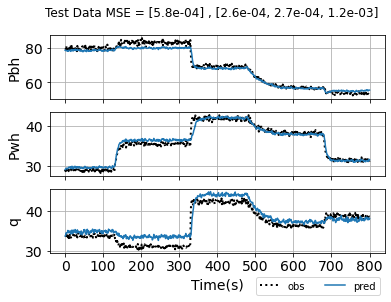

<Figure size 1440x288 with 0 Axes>

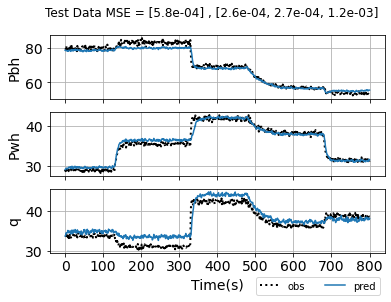

In [4]:
y=ds.train_y_full[ti:to,:,:]
u=ds.train_X[ti:to,0,:4]
t=np.arange(0,nsim+1,1)
plot_test(y, predict,[BCS_parameters.xc,BCS_parameters.x0])


## Creating a new set of exogenous for prediction

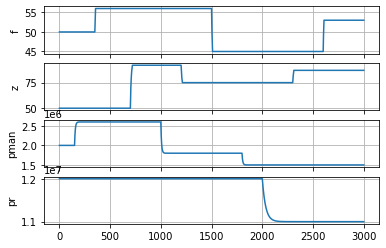

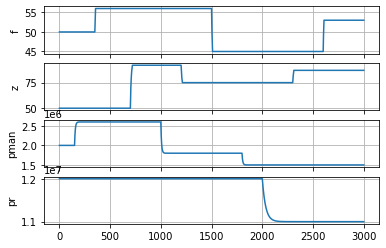

In [5]:
#Valores iniciais de simulação
tss=5 # Tempo inicial no estacionário
ts=1
pi=3.14159
npv=3
nmv=2
nde=2
tsim = 50*60; 
nsim=int(round(tsim/ts)+1)
#xss_n=xssn

Yk = np.zeros((npv,1))
Uk = np.zeros((nmv+nde,1))
Ymk = Yk
Ys = Yk
Ymin = Yk
Ymax = Yk

# fill vector x 
def lpf(x, omega_c, T):
    """Implement a first-order low-pass filter. 
    The input data is x, the filter's cutoff frequency is omega_c 
    [rad/s] and the sample time is T [s].  The output is y.
    """
    N=x.shape[0]
    y = x
    alpha = (2-T*omega_c)/(2+T*omega_c)
    beta = T*omega_c/(2+T*omega_c)
    for k in range(1, N):
        y[k] = alpha*y[k-1] + beta*(x[k]+x[k-1])
    return y

def step_function(tsim):
    x=np.arange(0,tsim)
    val_pm=[20e5,26e5,18e5,15e5]
    val_z=[50,100,75,95]
    val_f=[50,63,45,60]
    val_pr=[1.2e7,1.1e7]
    list_f=[(x >= 0) & (x<350), (x >= 350) & (x < 1500),(x >= 1500) & (x < 2600), x>=2600]
    list_z=[(x >= 0) & (x<700), (x >= 700) & (x < 1200), (x >= 1200) & (x < 2300),x>=2300]
    list_pm=[(x >= 0) & (x<150),  (x >=150) & (x<1000),(x >= 1000) & (x < 1800), x>=1800]
    list_pr=[(x >= 0) & (x<2000),   x>=2000]
    pm=np.piecewise(x,list_pm,val_pm)
    fk=np.piecewise(x,list_f, val_f)
    zc=np.piecewise(x,list_z, val_z)
    pr_z=np.piecewise(x,list_pr, val_pr)

 
    Wn=2*pi*0.05
    Wn2=2*pi*0.01
    pm_f=lpf(pm,Wn,1)
    pr_f=lpf(pr_z,Wn2,1)
    return np.array([lpf(fk,Wn,1),lpf(zc,Wn2*4,1),pm_f,pr_f])

label = ['f(Hz)',"zc", "pm(bar)", "Pr(bar)"];
f,zc,pm,pr=step_function(tsim)
entradas=[f,zc,pm,pr]
plot_u(entradas)



### Using the same initial conditions

In [6]:
#Initial conditions
nsim=1000
xi=np.array([7.92750470e+06, 2.90972936e+06], ndmin=2) #bar
ui=np.array([4.95914975e+01, 5.00190605e+01, 1.99149787e+06, 1.18634314e+07],ndmin=2) #Hz, 0-100%, bar,bar
#----------------------------------------------------------------
# Normalizar
xi=BCS_parameters.normalizar_x(xi)
#xi=[xi[0,0],xi[0,1]]
ui=BCS_parameters.normalizar_u(ui)
Xi=tf.convert_to_tensor(np.repeat([xi],20,axis=1), dtype=tf.float32)# Replicate to build NN input
Ui=tf.convert_to_tensor(np.repeat([ui],20,axis=1), dtype=tf.float32) # Replicate to build NN input


### Normalizing exogenous inputs

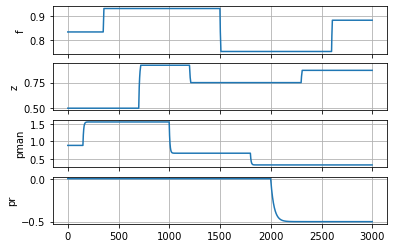

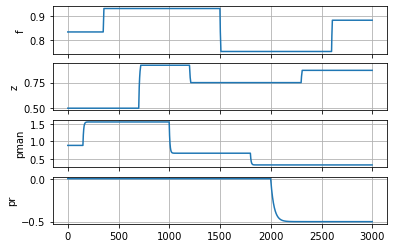

In [7]:
un=BCS_parameters.normalizar_u(np.array(entradas).T)
un.shape
plot_u(un.T)

### Prediction

In [8]:
y0=predictor.model(tf.concat([Ui,Xi],2))

predict=y0
nsteps=ds.n_steps_in
for i in range(nsim):
        Xi=tf.concat([Xi[:,1:,:],y0[:,:,:-1]],1) # Remove older time-step and update states vector with new predictions (remove q)
        Ui=tf.concat([Ui[:,1:,:],np.array([un[i:i+1,:]])],1) # Remove older time-step and update exogenous vector with the next time-step
        y0=predictor.model(tf.concat([Ui,Xi],2)) # Compute the next prediction
        predict=tf.concat([predict,y0],0) # Store        
predict=predict.numpy()
ti=0;to=ti+nsim+1;

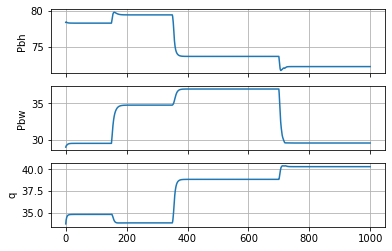

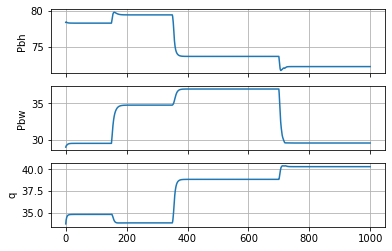

In [9]:
t=np.arange(0,nsim+1,1)
xp=predict[:,0,:]*BCS_parameters.xc+BCS_parameters.x0
plot_states_BCS(xp,t)
